## How to use

You should use the dataframes labeled gdf_2018_all, gdf_2010_all, gdf_2000_all, and gdf_combined.

Each dataframe has a column called "exp" that =1 if the tract is in the experimental (station) group, 0 if the tract is in the control group, and NaN (not a number/null value) if it is neither of those. 

In order to call only the experimental tracts, use `gdf_2000_all[gdf_2000_all['exp'] == 1]`.

In order to call only the control tracts, use `gdf_2000_all[gdf_2000_all['exp'] == 0]`.

In order to call both groups of tracts, use `gdf_2000_all[gdf_2000_all['exp'].notna()]`.

In order to use this filter in a visualization, map, etc, use `gdf_2018_all.loc[gdf_2018_all['exp'] == 1, 'med_hvalue']` where 1 indicates experimental tracts only and 'med_hvalue' is the column you want.

In order to see column names, use `gdf_2000_all.columns`. 

**You should not create new dataframes in order to avoid cluttering up the final document. Instead, use the above transformations on existing dataframes to limit the scope as needed.**

Remember to run the entire notebook! If something isn't working the way it should be, the very first troubleshooting step is to restart the kernel and run the notebook again from the top.

We have a new dataframe called gdf_combined which contains: 
- our three dependent variables: `housing_density`, `med_hhinc`, and `med_hvalue`
- our within-group variable `year`
- our between-group variable `exp`

This is used for the ANOVA, and can also be used to create time-series graphs.

## Data Loading/Cleaning

Note: this file assumes that it is located in the same directory as the 534group2 folder downloaded from github. In order to work it must be moved to that directory.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from shapely.geometry import Point, Polygon
from scipy import stats
from math import pi, cos, radians
from pyproj import Proj
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_2000 = pd.read_csv('534group2/ACS data/2000_tractdata.csv', dtype={'GEOID11':str})
df_2010 = pd.read_csv('534group2/ACS data/2010_tractdata.csv', dtype={'GEOID11':str})
df_2018 = pd.read_csv('534group2/ACS data/2018_tractdata.csv', dtype={'GEOID11':str})

In [3]:
gdf_tracts_2010 = gpd.read_file('534group2/shapefiles/tl_2017_06_tract/')
gdf_tracts_2000 = gpd.read_file('534group2/shapefiles/2000_Census_Tracts',dtype={'CT00':str})
gdf_stations = gpd.read_file('534group2/shapefiles/804_Gold_Stations_0316/')
gdf_goldline = gpd.read_file('534group2/shapefiles/804_Gold_Track_0316')

In [4]:
#Convert to CRS EPSG:2227, a California-centered projection that uses feet instead of degrees

gdf_goldline = gdf_goldline.to_crs('EPSG:2227')
gdf_stations = gdf_stations.to_crs('EPSG:2227')
gdf_tracts_2010 = gdf_tracts_2010.to_crs('EPSG:2227')
gdf_tracts_2000 = gdf_tracts_2000.to_crs('EPSG:2227')


In [5]:
goldtracts2010 = ['206020','206031','207103','206010','207102','206020',
                    '199000','185202','185310','199400','185100','183610',
                    '183620','183701','183810','183520','480600','480703',
                    '464000','463602','463700','461902','462302','462202',
                    '462201','462301','462700','463000','463102','462900']

controltracts2010 = ['203500','206032','197700','199700','207101',
                    '203500','185204','185203','199300',
                    '183220','183101','183820','183510','480704',
                    '480702','463601','463900','461700',
                    '463500','463601','462100','462400','463400',
                    '430600','463200','462800']

goldtracts2000 = ['206020','206030','207100','203500','207400',
                    '206010','207100','197700','199000','199400',
                    '199300','185202','185100','199300','183700','183810',
                    '183820','183610','183620','480704','480500','480703',
                    '480600','463900','464000','463700','463600','461900',
                    '462200','462300','462700','463102','463000','462900']
[str(i) for i in goldtracts2000]

controltracts2000 = ['203300','204410','197600','203600','207300','199000',
                    '197600','197300','185320','199201','199202','185310',
                    '186200','201301','183101','183520','183510','183300',
                    '183220','480804','480400','201120','183102','463800',
                    '463500','461700','464100','462000','462100','462400',
                    '462600','463101','430600','462500']

In [6]:
#clean data, extract tracts from GEOIDs
df_2000['GEOID11'] = df_2000['GEOID11'].str.slice(-6) #pull tracts out of GEOIDs
df_2010['GEOID11'] = df_2010['GEOID11'].str.slice(-6) #pull tracts out of GEOIDs
df_2018['GEOID11'] = df_2018['GEOID11'].str.slice(-6) #pull tracts out of GEOIDs

df_2000 = df_2000.set_index('GEOID11') #set tracts as index
df_2010 = df_2010.set_index('GEOID11') #set tracts as index
df_2018 = df_2018.set_index('GEOID11') #set tracts as index



In [7]:
#Clean data, only works with simple .csv files DO NOT OPEN THE FILES IN EXCEL I literally spent 2 hours of my life on this cell 

df_2018['med_hhinc'] = df_2018['med_hhinc'].replace({'250,000+':'250000','-':'0'})
df_2018['pct_poverty'] = df_2018['pct_poverty'].replace({'-':'0'})
df_2018['uemp_rate'] = df_2018['uemp_rate'].replace({'-':'0'})

df_2000clean = ['med_hhinc',
       'pop', 'pct_white', 'pct_black', 'pct_asian', 'pct_other', 'tol_hu',
       'med_hvalue', 'pct_noins', 'pct_poverty']
df_2010clean = ['med_hhinc','pop','pct_white','pct_black','pct_asian','pct_other', 'tol_hu',
       'med_hvalue', 'pct_poverty', 'med_rent']
df_2018clean = ['med_hhinc','pop','pct_white','pct_black','pct_asian','pct_other', 'tol_hu',
       'med_hvalue', 'pct_poverty', 'med_rent'] 

df_2000[df_2000clean] = df_2000[df_2000clean].astype(float)
df_2010[df_2010clean] = df_2010[df_2010clean].astype(float)
df_2018[df_2018clean] = df_2018[df_2018clean].astype(float)

In [8]:
#IGNORE, DEBUGGING ONLY

# counter = 0
# for i in goldtracts2000:
#     try:
#         gdf_tracts_2010.loc[gdf_tracts_2000['CT00'] i]
#         print(counter, '    ',gdf_tracts_2000['CT00'].loc[i])
#     except KeyError:
#         print(counter, '    ','Tract',i,'does not exist.')
#     counter = counter + 1
    
# print(len(goldtracts2000))

# print(gdf_tracts_2000['CT00'].to_string())


In [9]:
#create new dataframes for station tracts
df_2018_stations = df_2018.loc[goldtracts2010]
df_2018_control = df_2018.loc[controltracts2010]

df_2010_stations = df_2010.loc[goldtracts2010]
df_2010_control = df_2010.loc[controltracts2010]

df_2000_stations = df_2000.loc[goldtracts2000]
df_2000_control = df_2000.loc[controltracts2000]

In [10]:
#creates dataframe called df_20xx_all that includes tracts from the station and control groups
#df_20xx_all has a column called 'exp' that =1 if tract is a station tract and 0 if tract is a control tract

df_2018_all = df_2018.loc[goldtracts2010 + controltracts2010]
df_2018_all['exp'] = [1 if i in goldtracts2010 else 0 for i,j in df_2018_all.iterrows()]

df_2010_all = df_2010.loc[goldtracts2010 + controltracts2010]
df_2010_all['exp'] = [1 if i in goldtracts2010 else 0 for i,j in df_2010_all.iterrows()]

df_2000_all = df_2000.loc[goldtracts2000 + controltracts2000]
df_2000_all['exp'] = [1 if i in goldtracts2000 else 0 for i,j in df_2000_all.iterrows()]

In [11]:
#CLean and merge gdf_tracts_2010 with 2018 ACS data in df_2018_all

gdf_tracts_2010['GEOID'] = gdf_tracts_2010['GEOID'].str.slice(-6) #pulls tracts out of GEOID column
df_2000_all['GEOID'] = df_2000_all['GEOID'].str.slice(-6) #pulls tracts out of GEOID column

#merge the datasets on census tract codes
gdf_2018_all = pd.merge(left=gdf_tracts_2010, right=df_2018_all, how='left', left_on='GEOID', right_on='GEOID11')
gdf_2010_all = pd.merge(left=gdf_tracts_2010, right = df_2010_all, how='left', left_on='GEOID', right_on='GEOID11')
gdf_2000_all = pd.merge(left=gdf_tracts_2000, right = df_2000_all, how='left', left_on='CT00', right_on='GEOID11')


### Create Variables

In [12]:
#unit conversions
gdf_2018_all['area_acres'] = gdf_2018_all['geometry'].area / 43560
gdf_2010_all['area_acres'] = gdf_2010_all['geometry'].area / 43560
gdf_2000_all['area_acres'] = gdf_2000_all['geometry'].area / 43560

gdf_2018_all['area_sqmi'] = gdf_2018_all['geometry'].area / 27878400
gdf_2010_all['area_sqmi'] = gdf_2010_all['geometry'].area / 27878400
gdf_2000_all['area_sqmi'] = gdf_2000_all['geometry'].area / 27878400


In [13]:
#create variable for housing density
gdf_2018_all['housing_density'] = gdf_2018_all['tol_hu'] / gdf_2018_all['area_acres']
gdf_2010_all['housing_density'] = gdf_2010_all['tol_hu'] / gdf_2010_all['area_acres']
gdf_2000_all['housing_density'] = gdf_2000_all['tol_hu'] / gdf_2000_all['area_acres']

#create variable for population density
gdf_2018_all['pop_density'] = gdf_2018_all['pop'] / gdf_2018_all['area_sqmi']
gdf_2010_all['pop_density'] = gdf_2010_all['pop'] / gdf_2010_all['area_sqmi']
gdf_2000_all['pop_density'] = gdf_2000_all['pop'] / gdf_2000_all['area_sqmi']

# #create variable for rent burden - no rent burden because we don't have 2000 rents but it's here if you want it
# gdf_2018_all['rent_burden'] = gdf_2018_all['med_hhinc'] / gdf_2018_all['med_rent'] 
# gdf_2018_all['is_burdened'] = [1 if i > 0.3 else 0 for i in gdf_2018_all['rent_burden']]

In [14]:
#convert med_hvalue to single dollars
gdf_2018_all['med_hvalue'] = gdf_2018_all['med_hvalue'] * 1000

In [15]:
#first, create new dataframes to do pre-combining work
gdf_2000_precombined = gdf_2000_all[gdf_2000_all['exp'].notna()]
gdf_2010_precombined = gdf_2010_all[gdf_2010_all['exp'].notna()]
gdf_2018_precombined = gdf_2018_all[gdf_2018_all['exp'].notna()]

gdf_2000_precombined = gdf_2000_precombined[['housing_density','med_hhinc','med_hvalue','exp']].reset_index()
gdf_2010_precombined = gdf_2010_precombined[['housing_density','med_hhinc','med_hvalue','exp']].reset_index()
gdf_2018_precombined = gdf_2018_precombined[['housing_density','med_hhinc','med_hvalue','exp']].reset_index()

gdf_2000_precombined['year'] = '2000'
gdf_2010_precombined['year'] = '2010'
gdf_2018_precombined['year'] = '2018'

#then, create a new dataframe containing all the subject tracts from all three datasets
gdf_combined = pd.concat([gdf_2000_precombined,gdf_2010_precombined,gdf_2018_precombined],axis=0)

## Visualizations

Seaborn has detailed instructions and an example gallery on its website: https://seaborn.pydata.org/examples/index.html

Colors: https://matplotlib.org/tutorials/colors/colormaps.html

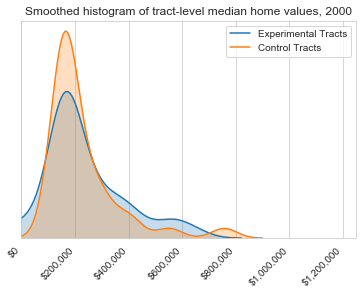

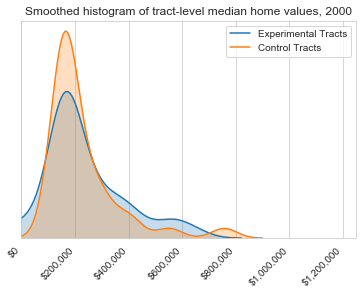

In [16]:
#Home value histogram
sns.set_style("whitegrid")
sns.despine()

valhist = sns.kdeplot(gdf_2000_all.loc[gdf_2000_all['exp'] == 1, 'med_hvalue'], label ='Experimental Tracts',
                    shade=True)
valhist = sns.kdeplot(gdf_2000_all.loc[gdf_2000_all['exp'] == 0, 'med_hvalue'], label = 'Control Tracts',
                    shade=True)
valhist.set_xlim(left=0,right=1250000)
valhist.set_title('Smoothed histogram of tract-level median home values, 2000')
valhist.set_xlabel('')
valhist.set_ylabel('')
valhist.get_yaxis().set_visible(False)

#this section formats the labels at the bottom of the graph
new_labels = ['${:,.0f}'.format(x) for x in valhist.get_xticks()]
valhist.set_xticklabels(new_labels,rotation=45, horizontalalignment='right')
valhist.get_figure()

#uncomment the below line to output your figure as an image file. Remember that the file will be overwritten every time the program is run.
#valhist.get_figure().savefig('med-value-hist.png', dpi=600, bbox_inches='tight')

The below plot requires special formatting because reasons, see https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot

<Figure size 432x288 with 0 Axes>

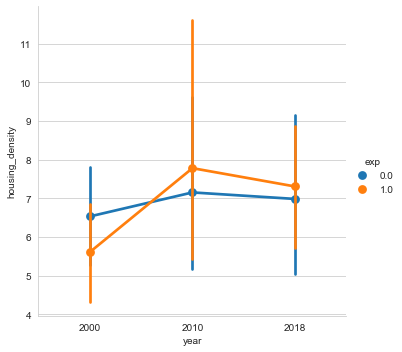

In [17]:
#Comparative line plot of home values, uses gdf_combined for time-series data
sns.set_style("whitegrid")
sns.despine()

cat = sns.catplot(x="year", y="housing_density", hue="exp", kind="point", data=gdf_combined);

#uncomment the below line to output your figure as an image file. Remember that the file will be overwritten every time the program is run.
#cat.get_figure().savefig('med-value-timeseries.png', dpi=600, bbox_inches='tight')

## Statistical Models

### Regression

In [18]:
gdf_2018_all.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID_x', 'NAME', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'GEOID_y', '16+_emp_rate', '16+_uemp_rate', 'uemp_rate',
       'med_hhinc', 'pop', 'pct_white', 'pct_black', 'pct_asian', 'pct_other',
       'tol_hu', 'med_hvalue', 'pct_noins', 'pct_poverty', 'city', 'metro',
       'med_rent', 'exp', 'area_acres', 'area_sqmi', 'housing_density',
       'pop_density'],
      dtype='object')

In [19]:
#syntax taken from Geoff's module
response = 'housing_density'
predictors = ['med_hvalue','exp']

data = gdf_2018_all[[response] + predictors].dropna()

X = data[predictors]
Y = data[response]

model = sm.OLS(Y, sm.add_constant(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        housing_density   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     7.228
Date:                Fri, 01 May 2020   Prob (F-statistic):            0.00170
Time:                        18:27:31   Log-Likelihood:                -157.51
No. Observations:                  55   AIC:                             321.0
Df Residuals:                      52   BIC:                             327.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0554      1.823      7.160      0.0

### Difference in Means

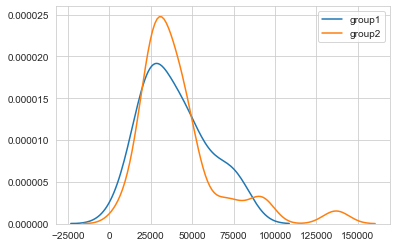

In [20]:
#syntax from Geoff
var = 'med_hhinc'

exp_tracts = gdf_2000_all[gdf_2000_all['exp'] == 1]
control_tracts = gdf_2000_all[gdf_2000_all['exp'] == 0]

group1 = exp_tracts[var]
group2 = control_tracts[var]

# # what are the distributions of these two groups?
ax = sns.kdeplot(group1, label='group1')
ax = sns.kdeplot(group2, label='group2', ax=ax)

In [21]:
print(int(group1.mean()))
print(int(group2.mean()))

39682
42132


In [22]:
group1.mean() - group2.mean()

-2449.3731601731633

In [23]:
# compute the t-stat and its p-value
t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False, nan_policy='omit')
p_value = p_value / 2 #convert two-tailed p-value to one-tailed
print(t_statistic)
print(p_value) 

-0.4386596019664918
0.3312417086507208


### ANOVA

See this link for instructions on performing an ANOVA test in python: https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/

Unfortunately statsmodels doesn't have support for betwen-group variances, which we need. The paper lays out a number of options. Pingouin looks promising but I don't think the course docker image has it, so you'd have to run this model using Python on your computer.

The test uses the dataframe gdf_combined: 
- our three dependent variables: `housing_density`, `med_hhinc`, and `med_hvalue`
- our within-group variable `year`
- our between-group variable `exp`

## Maps

Geopandas mapping website: https://geopandas.org/mapping.html

matplotlib colormaps: https://matplotlib.org/tutorials/colors/colormaps.html

(752609.9020109327, 802835.5125635618)

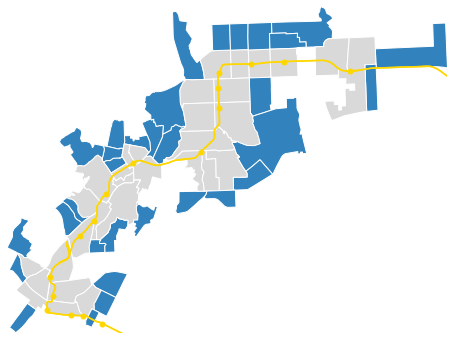

In [24]:
ax = gdf_goldline.plot(color='gold',figsize=(12,6))
ax = gdf_2000_all[gdf_2000_all['exp'].notna()].plot(column='exp',ax=ax,cmap='tab20c')
ax = gdf_stations.plot(ax=ax,c='gold',markersize=25)
ax.axis('off')

# this section zooms the map to only focus on the tracts
minx, miny, maxx, maxy = gdf_2000_all[gdf_2000_all['exp'].notna()].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)